In [25]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [26]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [27]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = [r'C:\Users\win\Desktop\GPU_TEST\seg_test', r'C:\Users\win\Desktop\GPU_TEST\seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [28]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:\Users\win\Desktop\GPU_TEST\seg_test


100%|██████████| 501/501 [00:00<00:00, 3151.58it/s]


Loading C:\Users\win\Desktop\GPU_TEST\seg_test


100%|██████████| 501/501 [00:00<00:00, 3131.83it/s]


# Test Model Creation

+ Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.

+ MaxPooling2D: The images get half sized.

+ Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.

+ Relu : given a value x, returns max(x, 0).

+ Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [29]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

train_images = train_images / 255.0 
test_images = test_images / 255.0

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
#history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

# Monitor GPU load, memory usage, and power consumption using nvidia-smi.

+ Parameters:

    + seconds (int): monitoring duration in seconds (default: 10 seconds)

In [41]:
import subprocess
import numpy as np
import time
import threading

# Define the maximum values for normalization
max_memory = 8196  # Maximum memory in MB
max_power = 100    # Replace with the actual power limit obtained from nvidia-smi

# Initialize lists to store monitoring data
gpu_load = []
memory_load = []
power_consumption = []

def monitor_gpu():
    while monitoring:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=utilization.gpu,utilization.memory,power.draw', '--format=csv,nounits,noheader'],
            stdout=subprocess.PIPE)
        output = result.stdout.decode('utf-8').strip()
        gpu_util, mem_util, power_draw = map(float, output.split(','))

        # Normalize values
        gpu_load.append(gpu_util)
        memory_load.append(mem_util / max_memory * 100)
        power_consumption.append(power_draw / max_power * 100)
        
        # Sleep for 0.1 seconds
        time.sleep(0.1)

In [42]:
# Set the monitoring flag to True
monitoring = True

In [43]:
# Start the GPU monitoring thread
monitor_thread = threading.Thread(target=monitor_gpu)
monitor_thread.start()

In [44]:
# Train the model
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split=0.2)


Epoch 1/20
19/19 [==============================] - 1s 46ms/step - loss: 9.1033e-05 - accuracy: 1.0000 - val_loss: 2.3300 - val_accuracy: 0.6533
Epoch 2/20
19/19 [==============================] - 1s 41ms/step - loss: 8.8549e-05 - accuracy: 1.0000 - val_loss: 2.3313 - val_accuracy: 0.6517
Epoch 3/20
19/19 [==============================] - 1s 41ms/step - loss: 8.5881e-05 - accuracy: 1.0000 - val_loss: 2.3325 - val_accuracy: 0.6533
Epoch 4/20
19/19 [==============================] - 1s 41ms/step - loss: 8.5961e-05 - accuracy: 1.0000 - val_loss: 2.3385 - val_accuracy: 0.6600
Epoch 5/20
19/19 [==============================] - 1s 41ms/step - loss: 7.8546e-05 - accuracy: 1.0000 - val_loss: 2.3594 - val_accuracy: 0.6550
Epoch 6/20
19/19 [==============================] - 1s 41ms/step - loss: 7.6152e-05 - accuracy: 1.0000 - val_loss: 2.3568 - val_accuracy: 0.6550
Epoch 7/20
19/19 [==============================] - 1s 41ms/step - loss: 7.4616e-05 - accuracy: 1.0000 - val_loss: 2.3735 - val_ac

In [45]:
# Stop the monitoring
monitoring = False
monitor_thread.join()

In [46]:
# Save the data to numpy arrays
np.save('gpu_load.npy', np.array(gpu_load))
np.save('memory_load.npy', np.array(memory_load))
np.save('power_consumption.npy', np.array(power_consumption))

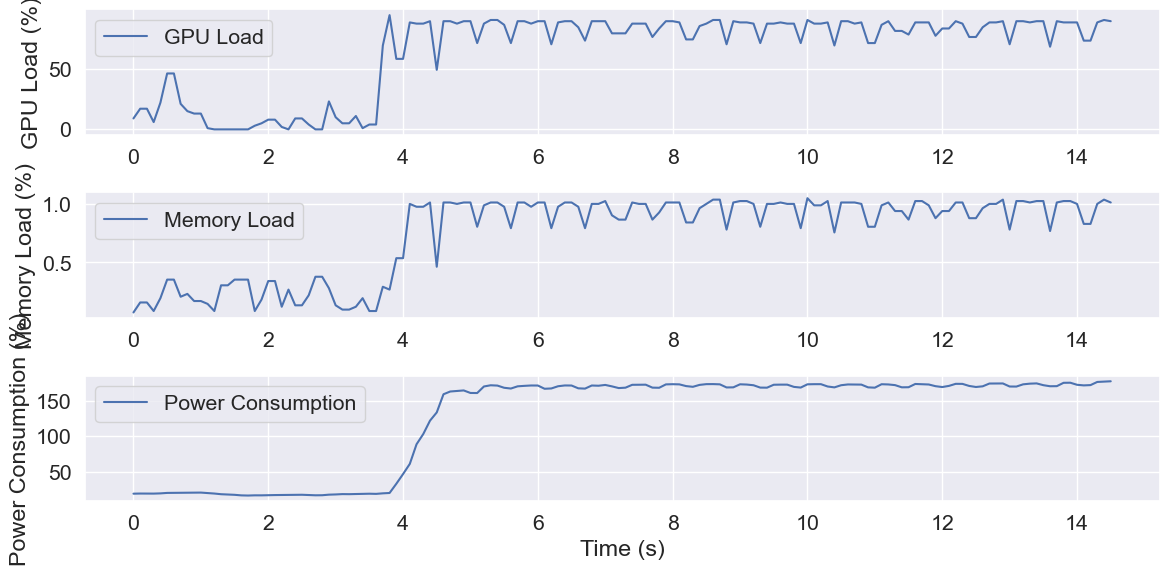

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Load the monitoring data
gpu_load = np.load('gpu_load.npy')
memory_load = np.load('memory_load.npy')
power_consumption = np.load('power_consumption.npy')

# Create time axis
time_axis = np.arange(0, len(gpu_load) * 0.1, 0.1)

# Plot GPU load
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time_axis, gpu_load, label='GPU Load')
plt.ylabel('GPU Load (%)')
plt.legend()

# Plot memory load
plt.subplot(3, 1, 2)
plt.plot(time_axis, memory_load, label='Memory Load')
plt.ylabel('Memory Load (%)')
plt.legend()

# Plot power consumption
plt.subplot(3, 1, 3)
plt.plot(time_axis, power_consumption, label='Power Consumption')
plt.ylabel('Power Consumption (%)')
plt.xlabel('Time (s)')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()
